In [1]:
import inspect
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix

%matplotlib inline  
%config InlineBackend.figure_format = 'png'
pd.options.display.max_columns = None

seed_ = 42

**Пути к файлам**

In [2]:
TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'

**Имена колонок**

In [3]:
ID = 'Id'
AGE = 'age'
EXP = 'years_of_experience'
PRICE = 'lesson_price'
QLF = 'qualification'
PHYS = 'physics'
CHEM = 'chemistry'
BIO = 'biology'
ENG = 'english'
GEO = 'geography'
HIST = 'history'
MEP = 'mean_exam_points'

TARGET = 'choose'

NUM_COLS = [AGE, EXP, PRICE, MEP]

CAT_COLS = [QLF, PHYS, CHEM, BIO, ENG, GEO, HIST]

#NEW_CAT_COLS = [SCORE_CAT, NO_CREDIT, BIG_LOAN_AMOUNT]

### Чтение данных TRAIN

In [4]:
df = pd.read_csv(TRAIN_FILE)
df.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
Id                     10000 non-null int64
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
mean_exam_points       10000 non-null float64
choose                 10000 non-null int64
dtypes: float64(11), int64(2)
memory usage: 1015.7 KB


### Обзор данных

**Обзор целевой переменной**

In [6]:
df[TARGET].value_counts()

0    8891
1    1109
Name: choose, dtype: int64

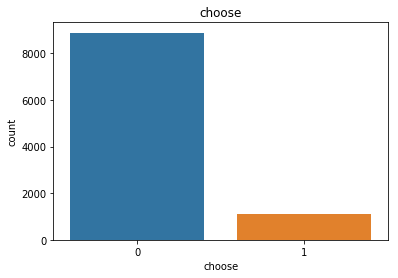

In [7]:
#plt.figure(figsize=(8, 5))
sns.countplot(x=TARGET, data=df)
plt.title(TARGET)
plt.show()

**Обзор категориальных признаков**

In [8]:
df[CAT_COLS].astype('str').describe()

,qualification,physics,chemistry,biology,english,geography,history
count,10000,10000,10000,10000,10000,10000,10000
unique,4,2,2,2,2,2,2
top,1.0,0.0,0.0,0.0,0.0,0.0,0.0
freq,4891,6294,8785,8828,9409,9723,9820


**Обзор числовых признаков**

In [9]:
df[NUM_COLS].describe()

,age,years_of_experience,lesson_price,mean_exam_points
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,45.800900,1.974800,1702.440000,64.435200
std,8.030274,1.766883,523.789062,13.595024
min,23.000000,0.000000,200.000000,33.000000
25%,40.000000,0.000000,1300.000000,55.000000
50%,46.000000,2.000000,1550.000000,63.000000
75%,51.000000,3.000000,2150.000000,74.000000
max,68.000000,9.000000,3950.000000,100.000000


### Корреляционный анализ

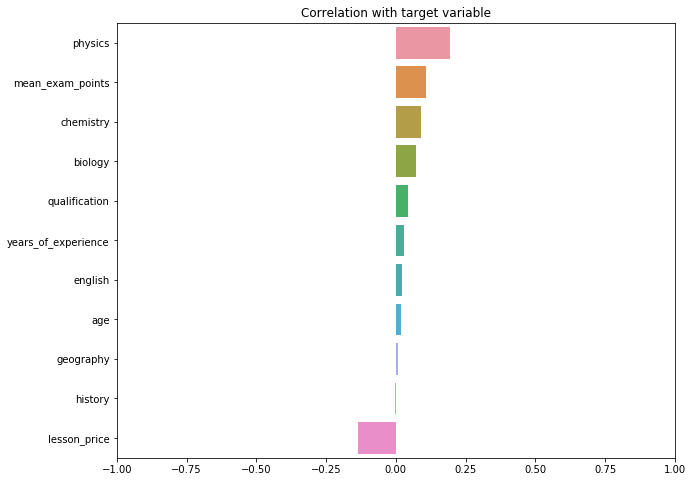

In [10]:
corr_with_target = df[NUM_COLS+CAT_COLS+[TARGET]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.xlim(-1.0, +1.0)
plt.title('Correlation with target variable')
plt.show()

In [11]:
corr = df[[TARGET]+NUM_COLS+CAT_COLS].corr()
corr.style.background_gradient(cmap='coolwarm')

,choose,age,years_of_experience,lesson_price,mean_exam_points,qualification,physics,chemistry,biology,english,geography,history
choose,1,0.0171648,0.0290105,-0.134013,0.109409,0.0421603,0.195183,0.0918779,0.0713097,0.0222266,0.00636628,-0.00469965
age,0.0171648,1,0.072635,0.000690912,0.00414112,-0.00777822,0.00414797,0.00380826,-0.0318891,0.00267584,-0.00545223,0.00925813
years_of_experience,0.0290105,0.072635,1,0.253459,0.208089,0.200629,0.0179762,-0.00405076,0.00132577,0.0119754,0.00206255,-0.00573186
lesson_price,-0.134013,0.000690912,0.253459,1,0.729215,0.797383,0.0110916,-0.00240455,0.017089,-0.00112707,0.0128253,0.000302722
mean_exam_points,0.109409,0.00414112,0.208089,0.729215,1,0.763883,0.186124,0.0298158,0.0396307,0.00617015,0.0266002,0.00534828
qualification,0.0421603,-0.00777822,0.200629,0.797383,0.763883,1,0.0105611,-0.00269163,0.0148362,-0.0010943,0.0147749,-0.00317696
physics,0.195183,0.00414797,0.0179762,0.0110916,0.186124,0.0105611,1,0.00489326,-0.00730171,-0.00528989,-0.0159679,0.000454752
chemistry,0.0918779,0.00380826,-0.00405076,-0.00240455,0.0298158,-0.00269163,0.00489326,1,0.0129434,-0.00883485,0.00437272,0.00950822
biology,0.0713097,-0.0318891,0.00132577,0.017089,0.0396307,0.0148362,-0.00730171,0.0129434,1,0.000968743,-0.0103516,-0.0119163
english,0.0222266,0.00267584,0.0119754,-0.00112707,0.00617015,-0.0010943,-0.00528989,-0.00883485,0.000968743,1,0.0145462,-0.00841429


### Оценка количественных признаков в разрезе целевой переменной

In [79]:
def kdeplt(df, target, feature):
    plt.subplot(1, 2, 1)
    feat_with_target_s = df[[feature, target]]
    feat_s = feat_with_target_s[feature]
    feat_target_0 = feat_s[feat_with_target_s[target] == 0]
    feat_target_1 = feat_s[feat_with_target_s[target] == 1]
    sns.kdeplot(feat_target_0, shade=True, label='0', color='g')
    sns.kdeplot(feat_target_1, shade=True, label='1', color='r')
    plt.xlabel(feature)
    plt.title('Target' + ' vs ' + feature)
    plt.subplot(1, 2, 2)
    sns.pointplot(x=target, y=feature, data=feat_with_target_s, capsize=.1)
    plt.title('Confidence intervals (95%)')
    plt.show()  

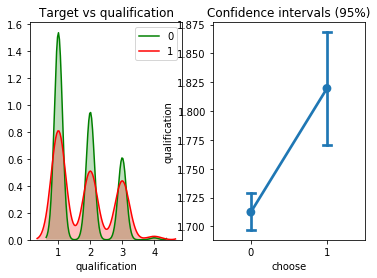

In [80]:
kdeplt(df, TARGET, QLF)

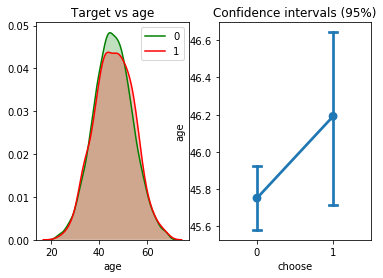

In [81]:
kdeplt(df, TARGET, AGE)

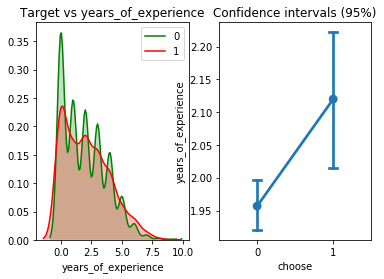

In [82]:
kdeplt(df, TARGET, EXP)

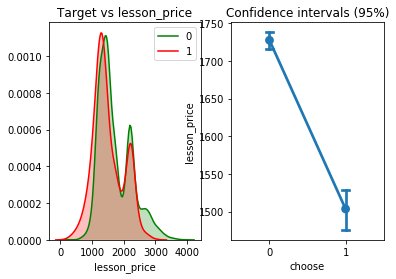

In [83]:
kdeplt(df, TARGET, PRICE)

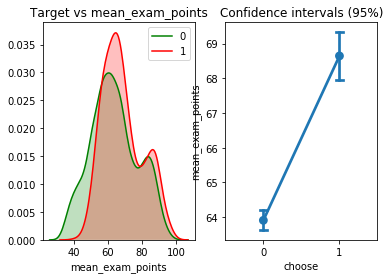

In [84]:
kdeplt(df, TARGET, MEP)

### Реализация алгоритма

In [156]:
def accuracy_score(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n_samples = y_true.shape[0]
    score = np.sum(y_true == y_pred) / n_samples
    return score

def precision_score(y_true, y_pred, pos_label=1):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    tp = np.sum((y_true == y_pred) & (y_pred == pos_label))
    fp = np.sum((y_true != y_pred) & (y_pred == pos_label))
    print(y_pred)
    assert (tp + fp) == 0
    score = tp / (tp + fp)
    return score

def recall_score(y_true, y_pred, pos_label=1):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    tp = np.sum((y_true == y_pred) & (y_pred == pos_label))
    fn = np.sum((y_true != y_pred) & (y_true == pos_label))
    assert (tp + fp) == 0
    score = tp / (tp + fn) 
    return score

def f1_score(y_true, y_pred, pos_label=1):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    tp = np.sum((y_true == y_pred) & (y_pred == pos_label))
    fp = np.sum((y_true != y_pred) & (y_pred == pos_label))
    fn = np.sum((y_true != y_pred) & (y_true == pos_label))
    assert (tp + fp) == 0
    assert (tp + fn) == 0
    precision = tp / (tp + fp)    
    recall = tp / (tp + fn)
    assert (precision + recall) == 0
    score = 2 * precision * recall / (precision + recall)
    return score

In [137]:
class Node:
    def __init__(self, index, threshold, true_branch, false_branch):
        self.index = index                # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.threshold = threshold        # значение порога
        self.true_branch = true_branch    # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
    
    def predict_object(self, obj):
        if obj[self.index] <= self.threshold:
            return self.true_branch.predict_object(obj)
        else:
            return self.false_branch.predict_object(obj)        
    
    def predict(self, x):
        return np.array([self.predict_object(obj) for obj in x])
    
    def predict_object_proba(self, obj):
        if obj[self.index] <= self.threshold:
            return self.true_branch.predict_object_proba(obj)
        else:
            return self.false_branch.predict_object_proba(obj)
        
    def predict_proba(self, x):
        return np.array([self.predict_object_proba(obj) for obj in x])
        
class Leaf:
    def __init__(self, y):
        self.n_samples_ = len(y)
        
        classes = {}  
        proba = {}
        for label in y:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        for class_ in classes:
            proba[class_] = classes[class_] / self.n_samples_
   
        self.prediction = max(classes, key=classes.get)
        self.proba = proba
        
    def predict_object(self, obj):
        return self.prediction
    
    def predict_object_proba(self, obj):
        return self.proba
        
def get_bootstrap(x, y, n):
    n_samples = x.shape[0]
    bootstrap = []
    
    for i in range(n):
        b_x = np.zeros(x.shape)
        b_y = np.empty(y.shape, dtype=np.object_)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_x[j] = x[sample_index]
            b_y[j] = y[sample_index]
        bootstrap.append((b_x, b_y))
        
    return bootstrap

def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

def quality(y_left, y_right, score, split_func):
    p = float(y_left.shape[0]) / (y_left.shape[0] + y_right.shape[0])
    return score - p * split_func(y_left) - (1 - p) * split_func(y_right)

def split(x, y, index, threshold):
    left = np.where(x[:, index] <= threshold)
    right = np.where(x[:, index] > threshold)
        
    x_true = x[left]
    x_false = x[right]
    y_true = y[left]
    y_false = y[right]
        
    return x_true, x_false, y_true, y_false

def get_subsample(len_sample):
    sample_indexes = [i for i in range(len_sample)]
    random.shuffle(sample_indexes)
    
    subsample = []
    len_subsample = int(np.sqrt(len_sample))
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
    
    return subsample

def find_best_split(x, y, split_func, min_samples_leaf):
    score = split_func(y)

    best_quality = 0
    best_threshold = None
    best_index = None
    
    n_features = x.shape[1]
    
    #subsample = get_subsample(n_features)
    
    #for index in subsample:
    for index in range(n_features):
        t_values = np.unique([row[index] for row in x])
        
        for threshold in t_values:
            x_true, x_false, y_true, y_false = split(x, y, index, threshold)

            if len(x_true) < min_samples_leaf or len(x_false) < min_samples_leaf:
                continue
            
            current_quality = quality(y_true, y_false, score, split_func)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_threshold, best_index = current_quality, threshold, index

    return best_quality, best_threshold, best_index

def build_tree(x, y, split_func, max_depth, min_samples_split, min_samples_leaf, tol=1e-3):
    # max_depth - контроль глубины
    if max_depth == 0:
        return Leaf(y)

    # min_samples_split - контроль минимально необходимого количества объектов для разделения
    if len(x) < min_samples_split:
        return Leaf(y)

    # min_samples_leaf - контроль минимально необходимого количества объектов в листе
    quality, threshold, index = find_best_split(x, y, split_func, min_samples_leaf)

    # прекращаем рекурсию, когда нет прироста в качества
    if quality < tol:
        return Leaf(y)

    max_depth -= 1

    x_true, x_false, y_true, y_false  = split(x, y, index, threshold)

    # рекурсивно строим два поддерева
    true_branch = build_tree(x_true, y_true, split_func, max_depth, min_samples_split, min_samples_leaf)
    false_branch = build_tree(x_false, y_false, split_func, max_depth, min_samples_split, min_samples_leaf)

    # возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, threshold, true_branch, false_branch)
    
class RandomForestModel(BaseEstimator):
    def __init__(self, n_trees=10, split_func=gini, max_depth=1e10, min_samples_split=2, min_samples_leaf=1, 
                 bootstrap=True, random_state=None):
        self.n_trees = n_trees
        self.split_func = split_func
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.forest = None
        self.n_features_ = 0
        self.n_classes_ = 0
        self.classes_ = None
        
    def fit(self, x, y):
        random.seed(self.random_state)
        
        x = np.array(x)
        y = np.array(y)
        
        self.n_features_ = x.shape[1]
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
    
        if self.bootstrap: 
            bootstrap = get_bootstrap(x, y, self.n_trees)
        else:
            bootstrap = [(x, y)]
    
        self.forest = []
        for b_x, b_y in bootstrap:
            self.forest.append(build_tree(b_x, b_y, self.split_func, self.max_depth, 
                                          self.min_samples_split, self.min_samples_leaf))
        
        return None
    
    def predict(self, x):
        if self.forest == None:
            return None
        
        x = np.array(x)

        predictions = []
        for tree in self.forest:
            predictions.append(tree.predict(x))

        predictions_per_object = list(zip(*predictions))

        y_pred = []
        for obj in predictions_per_object:
            y_pred.append(max(set(obj), key=obj.count))

        return np.array(y_pred)
    
    def predict_proba(self, x):
        if self.forest == None:
            return None
        
        x = np.array(x)
        
        forest_probas = []
        for obj in x:
            tree_probas = []
            for tree in self.forest:
                tree_proba = tree.predict_object_proba(obj)
                proba_array = np.zeros(self.n_classes_)
                for idx, class_ in enumerate(self.classes_):
                    if class_ in tree_proba.keys():
                        proba_array[idx] = tree_proba[class_]
                tree_probas.append(proba_array)
            avg_tree_probas = np.mean(np.array(tree_probas), axis=0)
            forest_probas.append(avg_tree_probas)
            
        return np.array(forest_probas)

### Моделирование

In [14]:
def balance_df_by_target(df, target_name, random_state=None):
    random.seed(random_state)
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [150]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [67]:
FEAT_COLS = NUM_COLS+CAT_COLS

In [68]:
x = df[FEAT_COLS]
y = df[TARGET]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed_)

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

In [70]:
params = {'n_estimators':[10, 20, 30, 50, 100, 150, 200], 
          'max_depth':[3, 5, 7, 10, 20, 30]}
clf = RandomForestClassifier(criterion='gini', random_state=seed_, class_weight='balanced_subsample')
rs = RandomizedSearchCV(clf, params, scoring='roc_auc', cv=5, n_jobs=-1)
%time rs.fit(x_train, y_train)
rs.best_params_, rs.best_score_

Wall time: 9.32 s


({'n_estimators': 150, 'max_depth': 7}, 0.8070485505081476)

In [71]:
from sklearn.metrics import roc_auc_score

In [72]:
y_train_pred = rs.predict(x_train)
train_score = roc_auc_score(y_train, y_train_pred)
y_test_pred = rs.predict(x_test)
test_score = roc_auc_score(y_test, y_test_pred)
print(train_score, test_score)

0.7719562243502052 0.7293578383300644


In [73]:
y_train_pred = rs.predict(x_train)
train_score = score_func(y_train, y_train_pred)
y_test_pred = rs.predict(x_test)
test_score = score_func(y_test, y_test_pred)
print(train_score, test_score)

0.4229263082947668 0.3870967741935484


In [74]:
df_for_balancing = pd.concat([x_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET)
df_balanced[TARGET].value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  import sys


0    6235
1    6120
Name: choose, dtype: int64

In [75]:
x_train = df_balanced.drop(columns=TARGET)
y_train = df_balanced[TARGET]

In [96]:
n_trees_list = [1]
max_depth_list = [1]
score_func = f1_score

In [138]:
best_score = -np.inf
best_params = {}
best_clf = None
for n_trees in n_trees_list:
    for max_depth in max_depth_list:
        print(n_trees, max_depth)
        clf = RandomForestModel(n_trees=n_trees, max_depth=max_depth, min_samples_leaf=1, random_state=seed_)
        %time clf.fit(x_train, y_train)
        y_train_pred = clf.predict(x_train)
        train_score = score_func(y_train, y_train_pred)
        y_test_pred = clf.predict(x_test)
        test_score = score_func(y_test, y_test_pred)
        print(train_score, test_score)
        if test_score > best_score:
            best_score = test_score
            best_params['n_trees'] = n_trees
            best_params['max_depth'] = max_depth
            best_clf = clf

1 1
Wall time: 984 ms
0.6408316008316007 0.2979564930784443


In [139]:
clf = best_clf
print(best_score, best_params)

0.2979564930784443 {'n_trees': 1, 'max_depth': 1}


In [144]:
y_test_pred = clf.predict(x_test)
y_test_pred_probs = clf.predict_proba(x_test)

In [153]:
y_test_pred_probs[:, 1]

array([0.34222573, 0.6513289 , 0.34222573, ..., 0.6513289 , 0.34222573,
       0.34222573])

In [157]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

[1 1 1 ... 1 1 1]


AssertionError: 

### Предсказание

In [41]:
df_test = pd.read_csv(TEST_FILE)
df_test.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,10000,32.0,2.0,2700.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0
1,10001,35.0,6.0,1800.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,71.0
2,10002,44.0,2.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0
3,10003,44.0,4.0,2950.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,92.0
4,10004,38.0,3.0,1400.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,58.0


In [42]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
Id                     10000 non-null int64
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
mean_exam_points       10000 non-null float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


In [43]:
%time df_test[TARGET] = clf.predict(df_test[FEAT_COLS])

Wall time: 219 ms


In [44]:
df_test.loc[:, ['Id', TARGET]].to_csv('VMaksimenko_predictions.csv', index=False)